# PHYS-2260 Final Project: Signatures with Complex Fourier Transforms

### Authors: Andrew Antenberg and Ethan Lior

In [4]:
!pip install pygame
!pip install pygame_widgets
!pip install svgpathtools

### Imports

In [5]:
import pygame
import pygame_widgets
from pygame_widgets.slider import Slider
from pygame_widgets.textbox import TextBox
from svgpathtools import svg2paths
from numpy import cos, sin, pi, sqrt, arctan2
import pygame.draw as draw
from pygame import gfxdraw
import numpy as np
from random import random
import matplotlib.pyplot as plt
import pygame.locals

pygame 2.5.2 (SDL 2.28.3, Python 3.10.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Applying the Fourier Transform

In [6]:
def fourier_term(signals, k):
  N = len(signals)
  X_k = complex()
  for n in range(N):
    theta = 2 * pi * k * n / N
    X_k += complex(cos(theta), -sin(theta)) * signals[n]
  return X_k / N

def fourier_transform(signals):  
  return [fourier_term(signals, k) for k in range(len(signals))]

In [7]:
class Wave:
  def __init__(self, frequency, amplitude, phase):
    self.frequency = frequency
    self.amplitude = amplitude
    self.phase = phase
  def __repr__(self):
    return f"Wave(freq={self.frequency}, amp={self.amplitude}, phase={self.phase})"

  @staticmethod
  def from_fourier_term(k, cmplx_num):
    r = cmplx_num.real
    i = cmplx_num.imag
    return Wave(k, sqrt(r * r + i * i), arctan2(i, r))

def generate_wave_info(signals):
  fourier_terms = fourier_transform(signals)
  return [Wave.from_fourier_term(k, term) for k, term in enumerate(fourier_terms)]

In [8]:
def read_file(filename):
  file = open(filename, "r")
  return [[float(num) for num in line.split(", ")] for line in file]

### Importing data for each letter and formatting into dictionary

Function to extract data from svg file and format into x and y position arrays

In [12]:
def extract(paths):
    xs = []
    ys = []
    for path in paths:
        for segment in path:
            # Extract coordinates from the segment
            for point in segment:
                x, y = point.real, point.imag
                xs.append(x)
                ys.append(y)
    return xs,ys

In [114]:
max_y = 0
alphabet = [chr(65 + i) for i in range(26)] + [chr(97 + i) for i in range(26)]
dc = dict() # Initializing dictionary for each letter
for letter in alphabet:
    is_uppercase = letter < 'a'
    route = f"assets/letters/{'upper' if is_uppercase else 'lower'}/{letter}.svg"
    paths,attributes = svg2paths(route)
    xs, ys = extract(paths)
    max_y = max(max_y, max(ys))
    dc[letter] = (xs, ys)

dc[' '] = [0, 30], [max_y, max_y]
letter_height = max_y

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


### Reading in user input

In [108]:
def generate_waves(points_x, points_y):
    x_waves = sorted(generate_wave_info(points_x), key=lambda x: -x.amplitude)
    y_waves = sorted(generate_wave_info(points_y), key=lambda x: -x.amplitude)
    return x_waves, y_waves
    



# Initializing array for x and y coordinates
def generate_text_vertices(word):    
    points_x = []
    points_y = []
    offset = 0
    for i in word:
        points_x.append(offset)
        points_y.append(letter_height)
        points_x += [x + offset for x in dc[i][0]]
        curr_max_y = max(dc[i][1])
        points_y += [letter_height - curr_max_y + y for y in dc[i][1]]
        points_x.append(points_x[-1])
        points_y.append(letter_height)
        offset = max(points_x)
    points_x = [point - offset / 2 for point in points_x]
    points_y = [point - letter_height / 2 for point in points_y]
    return points_x, points_y


In [109]:
class Point:
  def __init__(self, x, y):
    self.x = x
    self.y = y
  
  def __add__(self, other):
    return Point(self.x + other.x, self.y + other.y)
  
  def __sub__(self, other):
    return Point(self.x - other.x, self.y - other.y)
  
  def __iadd__(self, other):
    self.x += other.x
    self.y += other.y
    return self

  def __truediv__(self, num):
    return Point(self.x / num, self.y / num)
  
  def __mul__(self, num):
    return Point(self.x * num, self.y * num)
  
  def __repr__(self):
    return f"({self.x}, {self.y})"
  
  def __eq__(self, other):
    return self.x == other.x and self.y == other.y
  
  def __neq__(self, other):
    return not self.__eq__(other)
  
  def as_tuple(self):
    return (self.x, self.y)
  
  def as_ints(self):
    return (int(self.x), int(self.y))
  
  def on_grid(self, grid):
    col, row = self.as_ints()
    return grid[row][col]
  
  def set_grid_value(self, grid, value):
    col, row = self.as_ints()
    grid[row][col] = value

In [110]:
def get_info_text(xwaves, ywaves, x_points, y_points):
  return f"""General info:
        {len(x_points)} Vertices
        {len(xwaves)} Waves
X-Values:
        Max Radius: {max(xwaves, key=lambda x: x.amplitude).amplitude:.2f}
        Min Radius: {min(xwaves, key=lambda x: x.amplitude).amplitude:.2e}
        Max Frequency: {max(xwaves, key=lambda x: x.frequency).frequency}
        Min Frequency: {min(xwaves, key=lambda x: x.frequency).frequency}
Y-Values:
        Max Radius: {max(ywaves, key=lambda x: x.amplitude).amplitude:.2f}
        Min Radius: {min(ywaves, key=lambda x: x.amplitude).amplitude:.2e}
        Max Frequency: {max(ywaves, key=lambda x: x.frequency).frequency}
        Min Frequency: {min(ywaves, key=lambda x: x.frequency).frequency}""".split('\n')

In [111]:
# pygame setup
def display_fourier_transform(x_waves, y_waves, points_x, points_y, grid=None):
    pygame.init()

    background_color = (255, 255, 255)
    circle_color = (100, 100, 100)
    radius_color = (200, 200, 200)
    pointer_line_color = (255, 100, 100)

    old_line_color = (100, 100, 100)
    drawing_color = (0, 0, 50)
    widget_color = (0, 122, 255)

    screensize = Point(1280, 720)
    screencenter = screensize / 2
    screen = pygame.display.set_mode(screensize.as_tuple())
    clock = pygame.time.Clock()
    running = True
    time = 0
    points = []
    oldPoints = []
    epsilon = pi / 8

    slider_x = screencenter.x - 50
    slider = Slider(screen, slider_x, 600, 100, 10, min=1, max=5, step=1, initial=1, handleColour=widget_color)

    font = pygame.font.Font(None, 24)
    info_text = get_info_text(x_waves, y_waves, points_x, points_y)
    line_spacing = 40
    show_metadata = False

    output = TextBox(screen, slider_x, 630, 0, 0, fontSize=12)
    speed_label = TextBox(screen, slider_x, 642, 0, 0, fontSize=12)
    speed_label.setText('(Higher Speed = Lower Resolution)')
    speed_label.disable()
    output.disable()

    while running:
        output.setText(f'Speed: {slider.getValue()}x')

        events = pygame.event.get()
        # poll for events
        # pygame.QUIT event means the user clicked X to close your window
        for event in events:
            if event.type == pygame.QUIT:
                running = False
                pygame.quit()
            elif event.type == pygame.locals.KEYDOWN:
                if event.key == pygame.locals.K_SPACE:
                    show_metadata = not show_metadata

        # fill the screen with a color to wipe away anything from last frame
        screen.fill(background_color)

        
        if grid is not None:
            box_size = 10
            grid_top_left = screencenter - (Point(len(grid[0]) * box_size, len(grid * box_size)) / 2)
            draw.rect(screen, (100, 100, 100), (grid_top_left.as_tuple(), (Point(len(grid[0]), len(grid)) * box_size).as_tuple()), width=2)
            for row_index, row in enumerate(grid):
                for col_index, v in enumerate(row):
                    if v == 1:
                        draw.rect(screen, (0, 0, 0), ((grid_top_left + Point(col_index * box_size, row_index * box_size)).as_tuple(), (box_size, box_size)))

        if show_metadata:
            for i, line in enumerate(info_text):
                text_surface = font.render(line, True, (0, 0, 0))
                screen.blit(text_surface, (screensize.x - 250, 20 + i * line_spacing))

        currPointX = Point(screencenter.x, 100)
        for wave in x_waves:
            prevPoint = currPointX

            freq = wave.frequency
            radius = wave.amplitude
            phase = wave.phase

            offsetPoint = Point(cos(freq * time + phase), sin(freq * time + phase)) * radius
            currPointX = prevPoint + offsetPoint
            draw.aaline(screen, radius_color, prevPoint.as_tuple(), currPointX.as_tuple(), 2)
            radiusPoint = Point(radius, radius)
            topLeft = prevPoint - radiusPoint
            gfxdraw.aacircle(screen, int(prevPoint.x), int(prevPoint.y), int(radius), circle_color)
        
        currPointY = Point(100, screencenter.y)
        for wave in y_waves:
            prevPoint = currPointY

            freq = wave.frequency
            radius = wave.amplitude
            phase = wave.phase

            offsetPoint = Point(cos(freq * time + phase + (pi / 2)), sin(freq * time + phase + (pi / 2))) * radius
            currPointY = prevPoint + offsetPoint
            draw.aaline(screen, radius_color, prevPoint.as_tuple(), currPointY.as_tuple(), 2)
            radiusPoint = Point(radius, radius)
            topLeft = prevPoint - radiusPoint
            gfxdraw.aacircle(screen, int(prevPoint.x), int(prevPoint.y), int(radius), circle_color)

        time += slider.getValue() * (2 * pi / len(x_waves))
            
        finalPoint = (currPointX.x, currPointY.y)
        draw.aaline(screen, pointer_line_color, currPointX.as_tuple(), finalPoint)
        draw.aaline(screen, pointer_line_color, currPointY.as_tuple(), finalPoint)

        
        points.append((currPointX.x, currPointY.y))
        if (time >= 2 * pi - epsilon):
            oldPoints.append(points[0])
            points = points[1:]
        if len(oldPoints) >= 250:
            oldPoints = oldPoints[1:]

        if len(oldPoints) > 1:
            draw.aalines(screen, old_line_color, False, oldPoints)
        if len(points) > 1:
            draw.aalines(screen, drawing_color, False, points)
        
        draw.circle(screen, widget_color, (currPointX.x, currPointY.y), 5)

        
        pygame_widgets.update(events)
        pygame.display.flip()

        clock.tick(60)  # limits FPS to 60

    pygame.quit()

In [112]:
text = input('What would you like to be written?\n') #Taking in user input
points_x, points_y = generate_text_vertices(text)
x_waves, y_waves = generate_waves(points_x, points_y)

In [113]:
display_fourier_transform(x_waves, y_waves, points_x, points_y)

KeyboardInterrupt: 

## Brownian Motion

In [81]:
GRID_ROWS = 10
GRID_COLS = 10

INIT_ROW = 0
INIT_COL = 0


def generate_maze(grid_rows=GRID_ROWS, grid_cols=GRID_COLS, init_row=INIT_ROW, init_col=INIT_COL):
  grid = [[0 if i % 2 == 0 and j % 2 == 0 else 1 for i in range(grid_rows * 2 - 1)] for j in range(grid_cols * 2 - 1)]
  visited = [[False for _ in row] for row in grid]
  stack = [Point(init_col, init_row) * 2]

  while len(stack) != 0:
    p = stack.pop()
    row = int(p.y)
    col = int(p.x)
    visited[row][col] = True
    unvisited_neighbors = get_unvisited_neighbors(row, col, visited)
    if len(unvisited_neighbors) != 0:
      stack.append(p)
      random_neighbor_index = int(random() * len(unvisited_neighbors))
      random_neighbor = unvisited_neighbors[random_neighbor_index]
      random_neighbor.set_grid_value(visited, 0)
      in_between = (p + random_neighbor) / 2
      in_between.set_grid_value(grid, 0)
      stack.append(random_neighbor)
  return grid

def get_unvisited_neighbors(row, col, visited):
  num_rows = len(visited)
  num_cols = len(visited[row])
  offsets = [Point(-2, 0), Point(2, 0), Point(0, -2), Point(0, 2)]
  result = []
  for offset in offsets:
      new_p = Point(col, row) + offset
      if (0 <= new_p.y < num_rows) and (0 <= new_p.x < num_cols) and not new_p.on_grid(visited):
        result.append(new_p)
  return result

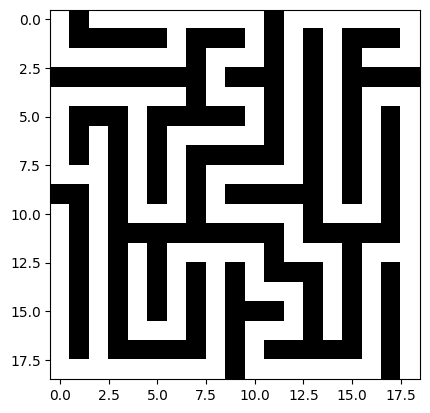

In [115]:
maze = generate_maze()
plt.imshow(maze, cmap="binary")

In [123]:
def random_offset():
  rand = random()
  if rand < 0.25:
    return Point(2, 0)
  elif rand < 0.5:
    return Point(-2, 0)
  elif rand < 0.75:
    return Point(0, 2)
  else:
    return Point(0, -2)

num_movers = 10
movers = [Point(INIT_COL, INIT_ROW) for _ in range(num_movers)]
positions = [[] for _ in range(num_movers)]

end_pos = Point(len(maze) - 1, len(maze[0]) - 1)

visited = [[0 for _ in row] for row in maze]
for mover_index, mover in enumerate(movers):
  while mover != end_pos:
    if mover == Point(0, 0):
      positions[mover_index] = []
    offset = random_offset()
    new_pos = mover + offset
    avg_pos = (new_pos + mover) / 2
    if 0 <= new_pos.x < len(maze[0]) and 0 <= new_pos.y < len(maze) and avg_pos.on_grid(maze) == 0:
      mover = new_pos
      avg_pos.set_grid_value(visited, 1)
      new_pos.set_grid_value(visited, 1)
      positions[mover_index].append(avg_pos)
      positions[mover_index].append(new_pos)

min_path = positions[0]
for path in positions:
  if len(path) < len(min_path):
    min_path = path
# plt.imshow(visited, cmap="hot")

print(len(min_path))


644


In [132]:
xs = [pos.x for pos in min_path]
ys = [pos.y for pos in min_path]

xs = [(x - (len(maze[0]) / 2)) * 10 + 5 for x in xs]
ys = [(y - (len(maze) / 2)) * 10 + 5 for y in ys]

paths,attributes = svg2paths('assets/confetti.svg')
confetti_xs, confetti_ys = extract(paths)
confetti_xs.append(confetti_xs[0])
confetti_ys.append(confetti_ys[0])

xs += [x + len(maze[0]) * 10 + 10 for x in confetti_xs] + [(x - (len(maze[0]) / 2)) * 10 + 5 for x in [len(maze[0]), -1, -1]]
ys += confetti_ys + [(y - (len(maze) / 2)) * 10 + 5 for y in [len(maze), len(maze), -1]]
x_waves, y_waves = generate_waves(xs, ys)

In [133]:
display_fourier_transform(x_waves, y_waves, xs, ys, maze)

KeyboardInterrupt: 